# Figure for AdaPID -- W2 vs $\beta$ for different $M$ and $T$

[GMM] Added .sample(n, seed) method.


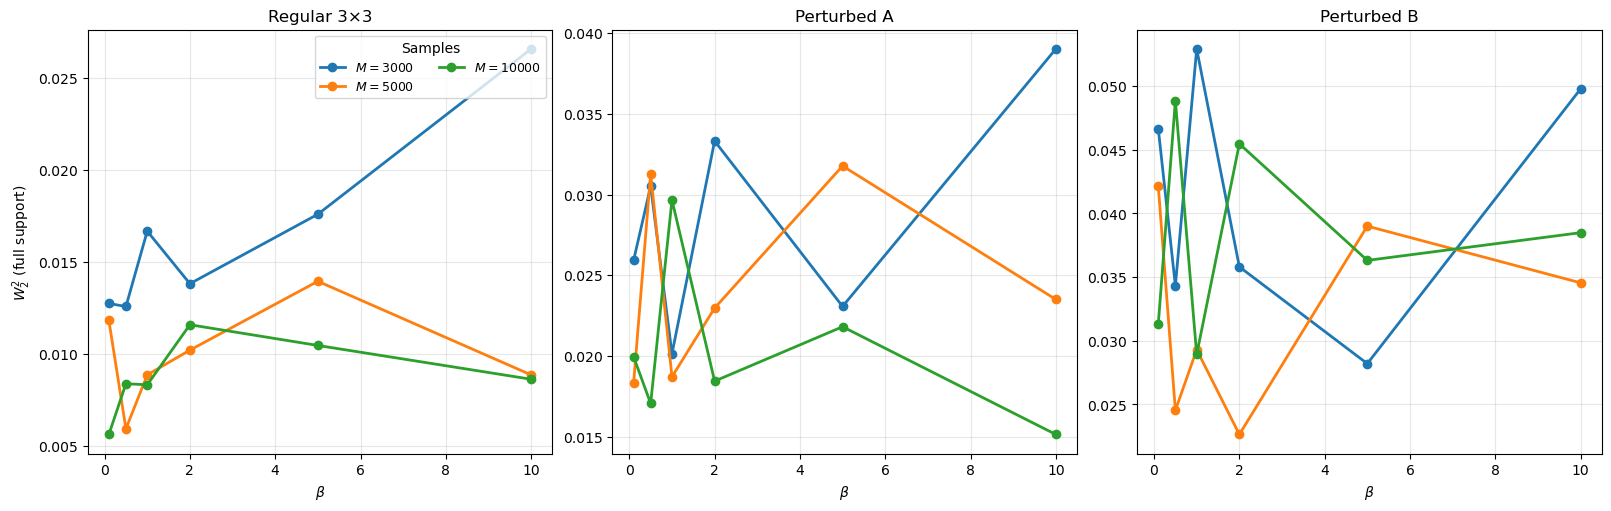

[saved] figs/W2full_vs_beta_varyM_T500_3models.png


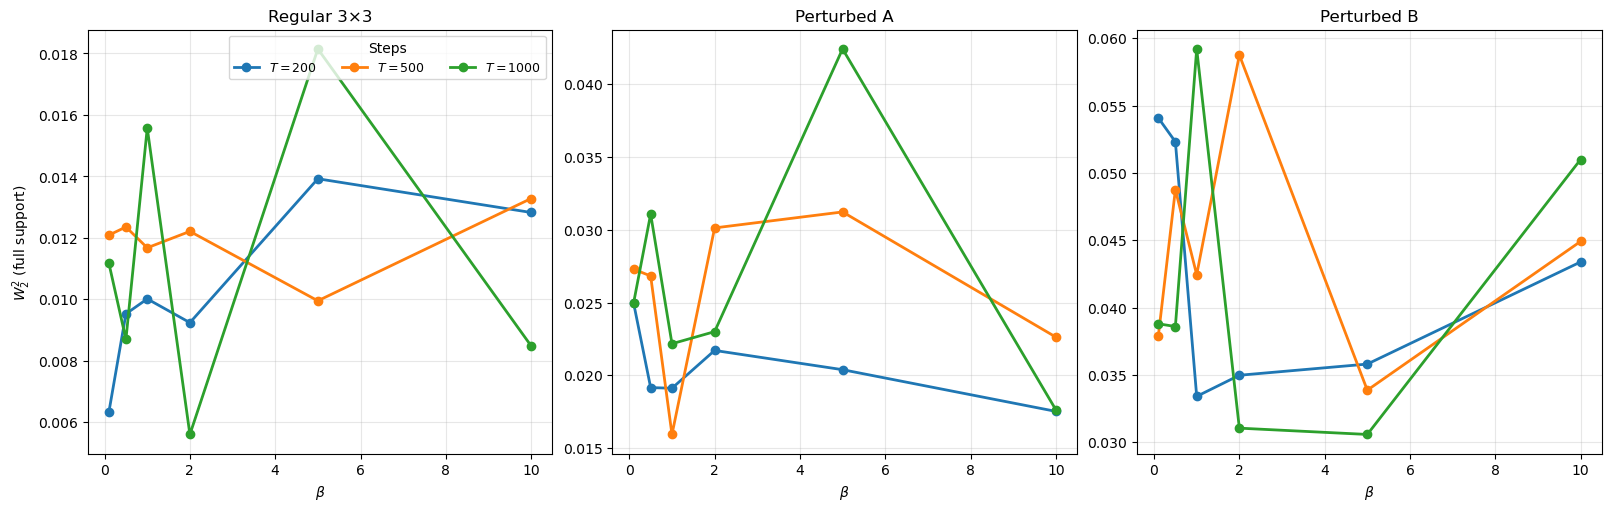

[saved] figs/W2full_vs_beta_varyT_M5000_3models.png
[best β] Regular 3×3: β*=0.1 with W2^2≈0.007289
[best β] Perturbed A: β*=0.5 with W2^2≈0.0176
[best β] Perturbed B: β*=0.1 with W2^2≈0.02385


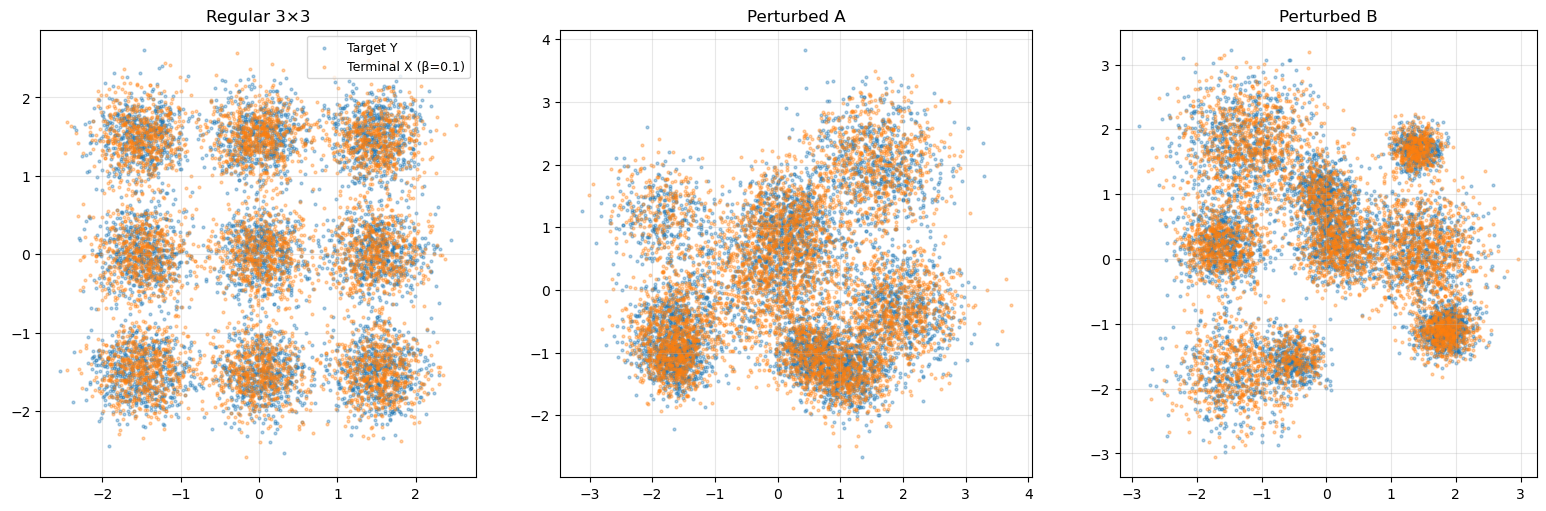

[saved] figs/terminals_scatter_bestbeta_3models_T500_M5000.png


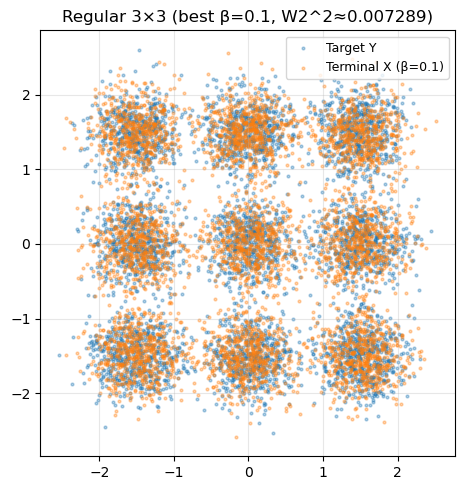

[saved] figs/terminals_scatter_bestbeta_Regular_3x3_T500_M5000.png


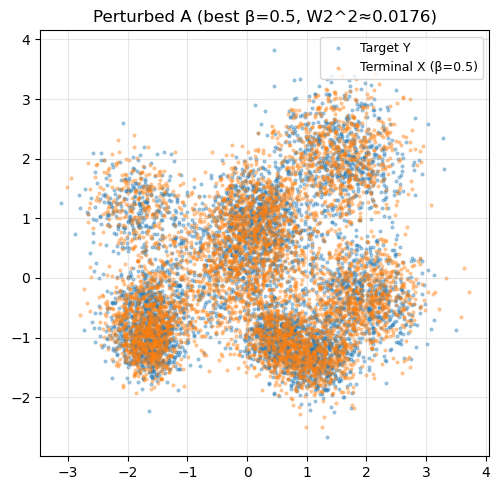

[saved] figs/terminals_scatter_bestbeta_Perturbed_A_T500_M5000.png


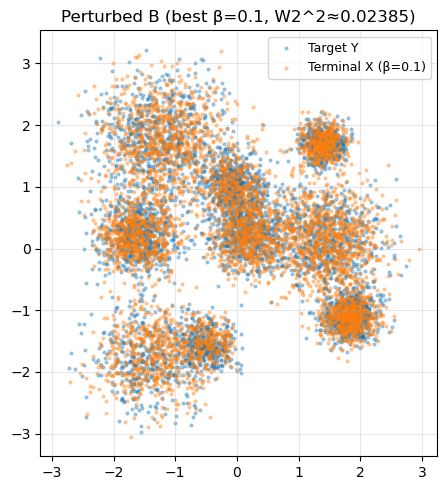

[saved] figs/terminals_scatter_bestbeta_Perturbed_B_T500_M5000.png


In [1]:
import sys
#sys.path.append('/mnt/data')
from ada_api_clean import *

# =======================================================
#  W2(full) dependence on β vs (i) M at fixed T and (ii) T at fixed M,
#           plus best-β scatter panels for each model.
#
# Outputs:
#   1) figs/W2full_vs_beta_varyM_T<Tfixed>_3models.png
#   2) figs/W2full_vs_beta_varyT_M<Mfixed>_3models.png
#   3) figs/terminals_scatter_bestbeta_3models_T<Tbase>_M<Mbase>.png
#      and per-model versions:
#         figs/terminals_scatter_bestbeta_<model>_T<Tbase>_M<Mbase>.png
#
# Assumes the following are already defined (from earlier cells):
#   - GMM(MU, SIG, PI), sample_gmm(gmm, M, rng)
#   - yhat_oracle_gmm(X, t, sched, gmm)
#   - BetaSchedulePWC.constant(...)
#   - alpha_K_gamma_from_schedule(sched, t)
#   - simulate_terminal_const_beta(...)
#   - wasserstein2_empirical(...)
# And that matplotlib, numpy are imported.
# =======================================================
import os, math, csv
import numpy as np
import matplotlib.pyplot as plt

os.makedirs("figs", exist_ok=True)
os.makedirs("tables", exist_ok=True)

# -------------------- Safety helpers --------------------
def _safe_tag(s: str) -> str:
    return (
        s.replace(" ", "_")
         .replace("×", "x")
         .replace("–", "-")
         .replace("/", "-")
    )

# -------------------- Models (reuse) --------------------
def build_regular_grid_gmm(a=1.5, sigma=0.3):
    xs = np.array([-a, 0.0, a], float)
    MU  = np.array([[xi, yj] for yj in xs for xi in xs], float)
    SIG = np.full(9, float(sigma))
    PI  = np.ones(9, float)/9.0
    return GMM(MU, SIG, PI)

def build_perturbed_gmm(seed, a=1.5, base_sigma=0.3,
                        jitter_frac=1/3, sig_scale=(0.5, 2.0),
                        weight_range=(0.5, 1.5)):
    rng = np.random.default_rng(int(seed))
    xs = np.array([-a, 0.0, a], float)
    centers = np.array([[xi, yj] for yj in xs for xi in xs], float)
    jitter_max = a * float(jitter_frac)
    MU  = centers + rng.uniform(-jitter_max, jitter_max, size=centers.shape)
    SIG = base_sigma * rng.uniform(sig_scale[0], sig_scale[1], size=9)
    w   = rng.uniform(weight_range[0], weight_range[1], size=9)
    PI  = w / np.sum(w)
    return GMM(MU, SIG, PI)

try:
    _ = regular; _ = pertA; _ = pertB
except NameError:
    regular = build_regular_grid_gmm(a=1.5, sigma=0.3)
    pertA   = build_perturbed_gmm(seed=20241005, a=1.5, base_sigma=0.3)
    pertB   = build_perturbed_gmm(seed=20241006, a=1.5, base_sigma=0.3)

models  = [("Regular 3×3", regular), ("Perturbed A", pertA), ("Perturbed B", pertB)]

# -------------------- Shared settings --------------------
# Use the same β-grid as in your previous cell (ensures consistency).
try:
    _ = beta_list
except NameError:
    beta_list = [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]

# OT + target sampling
REG_OT       = 0.02
M_tar_base   = 5000     # abundant target so K = min(M_sim, M_tar) is governed by M_sim
SEED_BASE    = 20251012  # different from the earlier cell to avoid seed collisions

# -------------------- 1) W2(full) vs β for multiple M at fixed T --------------------
Ms_for_panel1 = [3000, 5000,  10000]
T_fixed       = 500

# Store: results_panel1[model_name][M] = (betas, W2full_list)
results_panel1 = {}
for mi, (name, gmm_m) in enumerate(models):
    series_by_M = {}
    for Mi, M_sim in enumerate(Ms_for_panel1):
        W2_vals = []
        for bi, b in enumerate(beta_list):
            seed = SEED_BASE + 10_000*mi + 1_000*Mi + 19*bi
            # simulate terminal for X
            X = simulate_terminal_const_beta(b, gmm_m, M=M_sim, T=T_fixed, seed=seed)
            # target Y with CRN tied to (model, beta) but not to M (so curves compare the same Y)
            rngY = np.random.default_rng(SEED_BASE + 55_000*mi + 911*bi)
            Y, _ = sample_gmm(gmm_m, M_tar_base, rngY)
            K = min(len(X), len(Y))
            idxX = np.arange(K)
            idxY = rngY.choice(len(Y), size=K, replace=False)
            w2 = wasserstein2_empirical(X[idxX], Y[idxY], method="auto", reg=REG_OT)
            W2_vals.append(float(w2))
        series_by_M[M_sim] = (list(beta_list), W2_vals)
    results_panel1[name] = series_by_M

# Plot panel 1: three models side-by-side
fig1, axs1 = plt.subplots(1, 3, figsize=(16.0, 5.0), constrained_layout=True)
color_cycle = plt.rcParams["axes.prop_cycle"].by_key()["color"]
for ax, (name, series_by_M) in zip(axs1, results_panel1.items()):
    for ci, M_sim in enumerate(Ms_for_panel1):
        betas, w2s = series_by_M[M_sim]
        ax.plot(betas, w2s, marker="o",
                label=rf"$M={M_sim}$", color=color_cycle[ci % len(color_cycle)], lw=2.0)
    ax.set_title(name)
    ax.set_xlabel(r"$\beta$")
    ax.grid(True, alpha=0.3)
axs1[0].set_ylabel(r"$W_2^2$ (full support)")
axs1[0].legend(title="Samples", ncol=2, frameon=True, fontsize=9, loc="upper right")
fig1_path = f"figs/W2full_vs_beta_varyM_T{T_fixed}_3models.png"
fig1.savefig(fig1_path, dpi=300, bbox_inches="tight"); plt.show()
print("[saved]", fig1_path)

# -------------------- 2) W2(full) vs β for multiple T at fixed M --------------------
Ts_for_panel2 = [200, 500, 1000]
M_fixed       = 5000

# Store: results_panel2[model_name][T] = (betas, W2full_list)
results_panel2 = {}
for mi, (name, gmm_m) in enumerate(models):
    series_by_T = {}
    for Ti, T_sim in enumerate(Ts_for_panel2):
        W2_vals = []
        for bi, b in enumerate(beta_list):
            seed = SEED_BASE + 20_000*mi + 2_000*Ti + 23*bi
            X = simulate_terminal_const_beta(b, gmm_m, M=M_fixed, T=T_sim, seed=seed)
            # CRN target Y per (model, beta) but independent of T
            rngY = np.random.default_rng(SEED_BASE + 66_000*mi + 977*bi)
            Y, _ = sample_gmm(gmm_m, M_tar_base, rngY)
            K = min(len(X), len(Y))
            idxX = np.arange(K)
            idxY = rngY.choice(len(Y), size=K, replace=False)
            w2 = wasserstein2_empirical(X[idxX], Y[idxY], method="auto", reg=REG_OT)
            W2_vals.append(float(w2))
        series_by_T[T_sim] = (list(beta_list), W2_vals)
    results_panel2[name] = series_by_T

# Plot panel 2: three models side-by-side
fig2, axs2 = plt.subplots(1, 3, figsize=(16.0, 5.0), constrained_layout=True)
for ax, (name, series_by_T) in zip(axs2, results_panel2.items()):
    for ci, T_sim in enumerate(Ts_for_panel2):
        betas, w2s = series_by_T[T_sim]
        ax.plot(betas, w2s, marker="o",
                label=rf"$T={T_sim}$", color=color_cycle[ci % len(color_cycle)], lw=2.0)
    ax.set_title(name)
    ax.set_xlabel(r"$\beta$")
    ax.grid(True, alpha=0.3)
axs2[0].set_ylabel(r"$W_2^2$ (full support)")
axs2[0].legend(title="Steps", ncol=3, frameon=True, fontsize=9, loc="upper right")
fig2_path = f"figs/W2full_vs_beta_varyT_M{M_fixed}_3models.png"
fig2.savefig(fig2_path, dpi=300, bbox_inches="tight"); plt.show()
print("[saved]", fig2_path)

# -------------------- 3) Best-β scatter panels for baseline (M=5000, T=500) ------
M_base = 5000
T_base = 500

# Determine best β per model (argmin over W2(full) at baseline settings)
best_beta_by_model = {}
for mi, (name, gmm_m) in enumerate(models):
    best_b = None
    best_val = np.inf
    best_seed = None
    for bi, b in enumerate(beta_list):
        seed = SEED_BASE + 30_000*mi + 31*bi
        X = simulate_terminal_const_beta(b, gmm_m, M=M_base, T=T_base, seed=seed)
        rngY = np.random.default_rng(SEED_BASE + 88_000*mi + 101*bi)
        Y, _ = sample_gmm(gmm_m, M_tar_base, rngY)
        K = min(len(X), len(Y))
        idxX = np.arange(K)
        idxY = rngY.choice(len(Y), size=K, replace=False)
        w2 = wasserstein2_empirical(X[idxX], Y[idxY], method="auto", reg=REG_OT)
        if w2 < best_val:
            best_val  = float(w2)
            best_b    = float(b)
            best_seed = seed
    best_beta_by_model[name] = (best_b, best_val, best_seed)
    print(f"[best β] {name}: β*={best_b} with W2^2≈{best_val:.4g}")

# Create combined 1×3 scatter panel + per-model figures
K_plot = 5000  # limit plotted points for clarity/size
fig3, axs3 = plt.subplots(1, 3, figsize=(16.0, 5.0), constrained_layout=True)

for ax, (name, gmm_m) in zip(axs3, models):
    b_star, w2_star, seed_star = best_beta_by_model[name]
    # regenerate X, Y with the same seeds used for selection (ensures consistency)
    X = simulate_terminal_const_beta(b_star, gmm_m, M=M_base, T=T_base, seed=seed_star)
    rngY = np.random.default_rng(SEED_BASE + 88_000*models.index((name, gmm_m)) + 101*beta_list.index(b_star))
    Y, _ = sample_gmm(gmm_m, M_tar_base, rngY)

    # Choose matched K points for plotting
    K = min(len(X), len(Y), K_plot)
    idxX = np.arange(K)
    idxY = rngY.choice(len(Y), size=K, replace=False)

    ax.scatter(Y[idxY,0], Y[idxY,1], s=4, alpha=0.35, label="Target Y")
    ax.scatter(X[idxX,0], X[idxX,1], s=4, alpha=0.35, label=rf"Terminal X (β={b_star})")
    ax.set_title(f"{name}")
    ax.set_aspect("equal", adjustable="box")
    ax.grid(True, alpha=0.3)

axs3[0].legend(loc="upper right", fontsize=9, frameon=True)
fig3_path = f"figs/terminals_scatter_bestbeta_3models_T{T_base}_M{M_base}.png"
fig3.savefig(fig3_path, dpi=300, bbox_inches="tight"); plt.show()
print("[saved]", fig3_path)

# Also save individual per-model scatter panels
for (name, gmm_m), ax_idx in zip(models, range(3)):
    b_star, w2_star, seed_star = best_beta_by_model[name]
    # regenerate (to save individually)
    X = simulate_terminal_const_beta(b_star, gmm_m, M=M_base, T=T_base, seed=seed_star)
    rngY = np.random.default_rng(SEED_BASE + 88_000*ax_idx + 101*beta_list.index(b_star))
    Y, _ = sample_gmm(gmm_m, M_tar_base, rngY)
    K = min(len(X), len(Y), K_plot)
    idxX = np.arange(K)
    idxY = rngY.choice(len(Y), size=K, replace=False)

    plt.figure(figsize=(5.3, 5.0))
    plt.scatter(Y[idxY,0], Y[idxY,1], s=4, alpha=0.35, label="Target Y")
    plt.scatter(X[idxX,0], X[idxX,1], s=4, alpha=0.35, label=rf"Terminal X (β={b_star})")
    plt.title(f"{name} (best β={b_star}, W2^2≈{w2_star:.4g})")
    plt.gca().set_aspect("equal", adjustable="box")
    plt.grid(True, alpha=0.3)
    plt.legend(loc="upper right", fontsize=9, frameon=True)
    out_path = f"figs/terminals_scatter_bestbeta_{_safe_tag(name)}_T{T_base}_M{M_base}.png"
    plt.tight_layout(); plt.savefig(out_path, dpi=300, bbox_inches="tight"); plt.show()
    print("[saved]", out_path)


# Averaging the two figures above over 10 trials

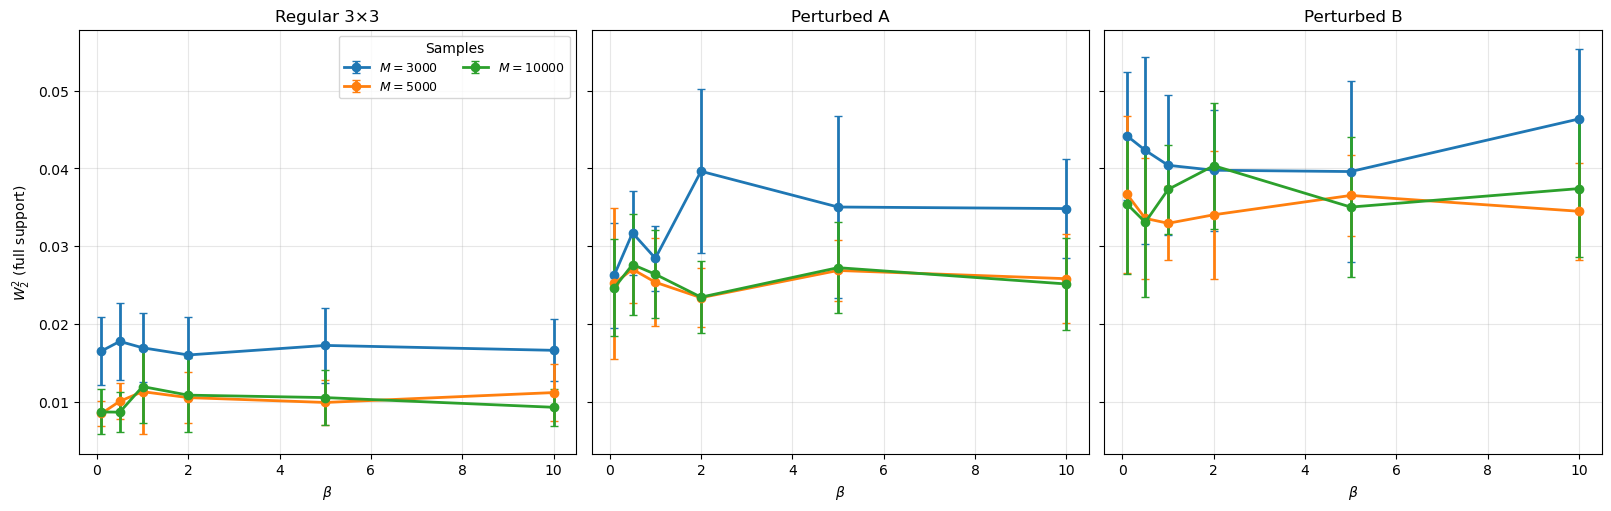

[saved] figs/W2full_vs_beta_varyM_T500_3models_avg.png


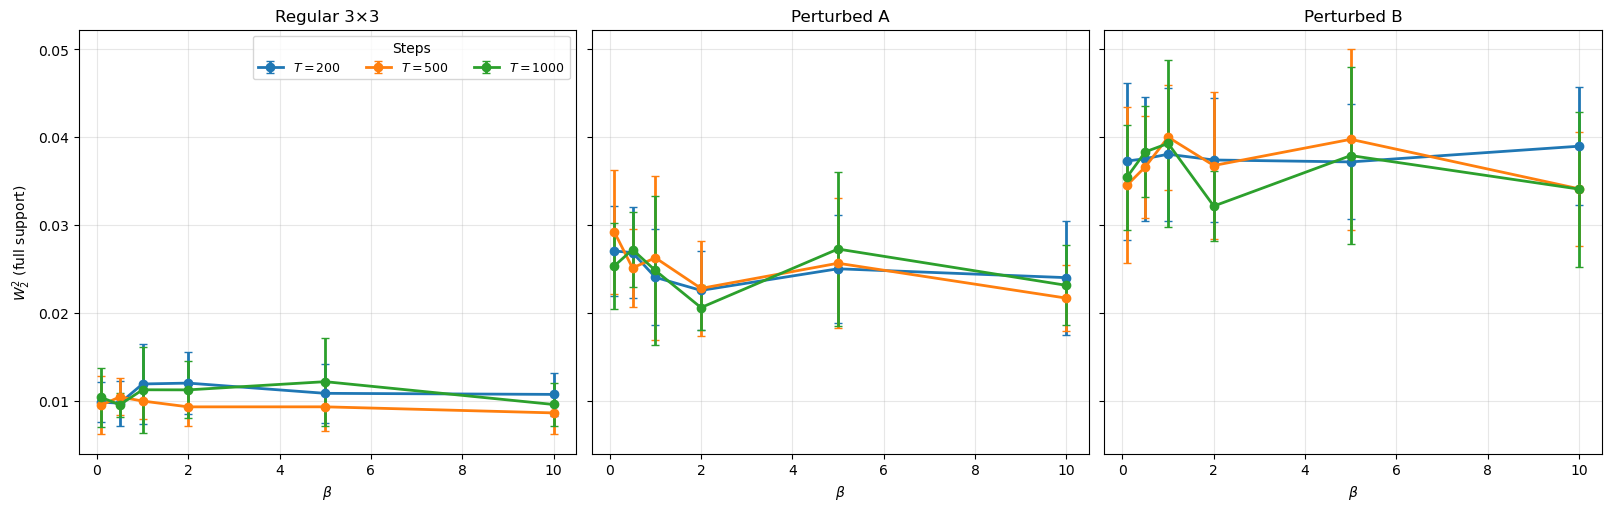

[saved] figs/W2full_vs_beta_varyT_M5000_3models_avg.png


In [2]:
# ==== NEW CELL: Averaged W2(full) curves over seeds (mean ± std error bars) ====
# Uses the SAME computations as your previous cell, only repeated N_REP times with new seeds.
# Requires the previous cell to have defined:
#   models (list of (name, gmm)), beta_list, REG_OT, M_tar_base, SEED_BASE,
#   Ms_for_panel1, T_fixed, Ts_for_panel2, M_fixed,
#   simulate_terminal_const_beta, sample_gmm, wasserstein2_empirical, numpy, matplotlib
#
# Outputs:
#   figs/W2full_vs_beta_varyM_T<Tfixed>_3models_avg.png
#   figs/W2full_vs_beta_varyT_M<Mfixed>_3models_avg.png

import numpy as np
import matplotlib.pyplot as plt
import os

os.makedirs("figs", exist_ok=True)

# How many repetitions to average over
N_REP = 10

# Use the same color cycle as before
color_cycle = plt.rcParams["axes.prop_cycle"].by_key()["color"]

# -------------------- 1) Averaged W2(full) vs beta for multiple M at fixed T --------------------
# results structure: results_panel1_avg[model_name][M] = (betas, mean, std)
results_panel1_avg = {}
for mi, (name, gmm_m) in enumerate(models):
    series_by_M = {}
    for Mi, M_sim in enumerate(Ms_for_panel1):
        # Collect W2 values as (N_REP, len(beta_list))
        W2_mat = np.zeros((N_REP, len(beta_list)), dtype=float)
        for rep in range(N_REP):
            for bi, b in enumerate(beta_list):
                # keep your seed structure, just offset by rep to avoid collisions
                seed_sim = SEED_BASE + rep*1_000_000 + 10_000*mi + 1_000*Mi + 19*bi
                # simulate terminal for X
                X = simulate_terminal_const_beta(b, gmm_m, M=M_sim, T=T_fixed, seed=seed_sim)
                # target Y: CRN per (model, beta), independent of M, offset by rep as well
                rngY = np.random.default_rng(SEED_BASE + rep*2_000_000 + 55_000*mi + 911*bi)
                Y, _ = sample_gmm(gmm_m, M_tar_base, rngY)
                K = min(len(X), len(Y))
                idxX = np.arange(K)
                idxY = rngY.choice(len(Y), size=K, replace=False)
                w2 = wasserstein2_empirical(X[idxX], Y[idxY], method="auto", reg=REG_OT)
                W2_mat[rep, bi] = float(w2)
        mean = W2_mat.mean(axis=0)
        std  = W2_mat.std(axis=0, ddof=0)
        series_by_M[M_sim] = (list(beta_list), mean, std)
    results_panel1_avg[name] = series_by_M

# Plot panel 1 (mean ± std)
fig1, axs1 = plt.subplots(1, 3, figsize=(16.0, 5.0), constrained_layout=True, sharey=True)
for ax, (name, series_by_M) in zip(axs1, results_panel1_avg.items()):
    for ci, M_sim in enumerate(Ms_for_panel1):
        betas, mean, std = series_by_M[M_sim]
        ax.errorbar(betas, mean, yerr=std, fmt="-o", lw=2.0, capsize=3,
                    label=rf"$M={M_sim}$", color=color_cycle[ci % len(color_cycle)])
    ax.set_title(name)
    ax.set_xlabel(r"$\beta$")
    ax.grid(True, alpha=0.3)
axs1[0].set_ylabel(r"$W_2^2$ (full support)")
axs1[0].legend(title="Samples", ncol=2, frameon=True, fontsize=9, loc="upper right")

fig1_path = f"figs/W2full_vs_beta_varyM_T{T_fixed}_3models_avg.png"
fig1.savefig(fig1_path, dpi=300, bbox_inches="tight"); plt.show()
print("[saved]", fig1_path)

# -------------------- 2) Averaged W2(full) vs beta for multiple T at fixed M --------------------
# results structure: results_panel2_avg[model_name][T] = (betas, mean, std)
results_panel2_avg = {}
for mi, (name, gmm_m) in enumerate(models):
    series_by_T = {}
    for Ti, T_sim in enumerate(Ts_for_panel2):
        W2_mat = np.zeros((N_REP, len(beta_list)), dtype=float)
        for rep in range(N_REP):
            for bi, b in enumerate(beta_list):
                seed_sim = SEED_BASE + rep*1_000_000 + 20_000*mi + 2_000*Ti + 23*bi
                X = simulate_terminal_const_beta(b, gmm_m, M=M_fixed, T=T_sim, seed=seed_sim)
                rngY = np.random.default_rng(SEED_BASE + rep*2_000_000 + 66_000*mi + 977*bi)
                Y, _ = sample_gmm(gmm_m, M_tar_base, rngY)
                K = min(len(X), len(Y))
                idxX = np.arange(K)
                idxY = rngY.choice(len(Y), size=K, replace=False)
                w2 = wasserstein2_empirical(X[idxX], Y[idxY], method="auto", reg=REG_OT)
                W2_mat[rep, bi] = float(w2)
        mean = W2_mat.mean(axis=0)
        std  = W2_mat.std(axis=0, ddof=0)
        series_by_T[T_sim] = (list(beta_list), mean, std)
    results_panel2_avg[name] = series_by_T

# Plot panel 2 (mean ± std)
fig2, axs2 = plt.subplots(1, 3, figsize=(16.0, 5.0), constrained_layout=True, sharey=True)
for ax, (name, series_by_T) in zip(axs2, results_panel2_avg.items()):
    for ci, T_sim in enumerate(Ts_for_panel2):
        betas, mean, std = series_by_T[T_sim]
        ax.errorbar(betas, mean, yerr=std, fmt="-o", lw=2.0, capsize=3,
                    label=rf"$T={T_sim}$", color=color_cycle[ci % len(color_cycle)])
    ax.set_title(name)
    ax.set_xlabel(r"$\beta$")
    ax.grid(True, alpha=0.3)
axs2[0].set_ylabel(r"$W_2^2$ (full support)")
axs2[0].legend(title="Steps", ncol=3, frameon=True, fontsize=9, loc="upper right")

fig2_path = f"figs/W2full_vs_beta_varyT_M{M_fixed}_3models_avg.png"
fig2.savefig(fig2_path, dpi=300, bbox_inches="tight"); plt.show()
print("[saved]", fig2_path)
